In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd

In [4]:
from fastai.callbacks.csv_logger import CSVLogger

In [5]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [6]:
experiment_name = "Equine-Fold-1"

In [26]:
train = list(set(['26_EIPH_566482 L Berliner Blau.svs',
                 '22_EIPH_575216 Berliner Blau.svs',
                 '25_EIPH_568150 Berliner Blau.svs',
                 '20_EIPH_576150 berliner blau.svs',
                 '15_EIPH_568320 berliner blau.svs',
                 '02_EIPH_574162 berliner blau.svs',
                 '18_EIPH_574882 R Berliner Blau.svs',
                 '13_EIPH_570370 Berliner Blau.svs',
                 '16_EIPH_576172 Turnbull blue-002.svs',
                 '19_EIPH_566933 L Berliner Blau.svs',
                 '04_EIPH_567017 Turnbull blue-001.svs',
                 '29_EIPH_566481 L Turnbull blue.svs',
                 '09_EIPH_563417 L berliner blau.svs',
                 '29_EIPH_566481 L Berliner Blau.svs',
                 '20_EIPH_576150 Turnbull blue.svs',
                 '27_EIPH_571557 berliner blau.svs',
                 '11_EIPH_575697 Turnbull blue-002.svs',
                 '31_EIPH_568354 Berliner Blau.svs',
                 '07_EIPH_574882 Berliner Blau-001.svs']))

val = list(set(['14_EIPH_568381 berliner blau-001.svs',
                 '01_EIPH_563479 Berliner Blau.svs',
                 '08_EIPH_574999 Berliner Blau.svs',
                 '16_EIPH_574882 R Berliner Blau.svs',
                 '17_EIPH_575796 Berliner Blau.svs',
                 '11_EIPH_575697 Berliner Blau.svs',
                 '23_EIPH_563476 Turnbull blue.svs',
                 '01_EIPH_563479 Turnbull blue.svs',
                 '24_EIPH_576255 Turnbull blue.svs',
                 '02_EIPH_574162 Turnbull blue-001.svs',
                 '27_EIPH_571557 Turnbull blue.svs',
                 '10_EIPH_563417 R Berliner Blau.svs',
                 '08_EIPH_574999 R Turnbull blue.svs',
                 '25_EIPH_568150 Turnbull blue.svs',
                 '21_EIPH_566482 R Turnbull blue.svs',
                 '09_EIPH_563417 L Turnbull blue.svs',
                 '05_EIPH_569923 Berliner Blau.svs',
                 '05_EIPH_569923 Turnbull blue.svs',
                 '04_EIPH_567017 Berliner Blau.svs']))

test = list(set(['14_EIPH_568381 Turnbull blue.svs',
                 '23_EIPH_563476 Berliner Blau-001.svs',
                 '24_EIPH_576255 Berliner Blau.svs',
                 '30_EIPH_588355 Berliner Blau.svs',
                 '26_EIPH_566482 L Turnbull blue.svs',
                 '18_EIPH_574882 Turnbull blue-002.svs',
                 '15_EIPH_568320 Turnbull blue.svs',
                 '17_EIPH_575796 Turnbull blue.svs',
                 '30_EIPH_568355 Turnbull blue.svs',
                 '22_EIPH_575216 Turnbull blue.svs',
                 '13_EIPH_570370 Turnbull blue-001.svs',
                 '31_EIPH_568354 Turnbull blue.svs',
                 '03_EIPH_566933 R Berliner Blau neu.svs',
                 '28_EIPH_569948 L berliner blau.svs',
                 '07_EIPH_574882 left lung Turnbull blue.svs',
                 '19_EIPH_566933 L Tunrbull blue.svs',
                 '28_EIPH_569948 L Turnbull blue.svs',
                 '10_EIPH_563417 R Turnbull blue-002.svs',
                 '03_EIPH_566933 R Turnbull blue.svs']))

In [27]:
annotations_path = Path("../../Statistics/EIPH_Annotations_Equine.pkl")
annotations = pd.read_pickle(annotations_path)

annotations_train = annotations[annotations["image_name"].isin(train)]
annotations_val = annotations[annotations["image_name"].isin(val)]
annotations_test = annotations[annotations["image_name"].isin(test)]

annotations.head()

,id,image_id,image_set,image_name,grade,vector,unique_identifier,user_id,deleted
0,1433999,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 32197, 'x2': 32338, 'y1': 15975, 'y2': ...",cafc4aa3-324f-4015-9451-ad7e5bee53f3,1,False
1,1434000,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 23069, 'x2': 23180, 'y1': 11514, 'y2': ...",979ef20e-6228-4cb3-ac9a-aecea6ad75c1,1,False
2,1434001,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 9045, 'x2': 9148, 'y1': 9711, 'y2': 9814}",ef87d780-5e2e-413e-a2ff-0712f6aa1532,1,False
3,1434002,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 10538, 'x2': 10645, 'y1': 10306, 'y2': ...",0f141dc4-5589-4e5a-a504-d77e7ad94683,1,False
4,1434003,3530,246,07_EIPH_574882 Berliner Blau-001.svs,0,"{'x1': 26013, 'x2': 26114, 'y1': 20873, 'y2': ...",f56de1f1-83ff-48d6-b67a-bfc1ea4e1349,1,False


In [31]:
slides_path = Path("../../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*/*.svs") if slide.name in train + val + test}
len(files)

57

In [32]:
size = 1024 
level = 0
bs = 16
train_images = 2500
val_images = 1500

In [33]:
train_files = []
val_files = []

for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["grade"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    train_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["grade"])
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    val_files.append(SlideContainer(slide_path, y=[bboxes, labels],  level=level, width=size, height=size))
    
train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [34]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [35]:
def get_y_func(x):
    return x.y

In [15]:
train =  ObjectItemListSlide(train_files, path=slides_path)
valid = ObjectItemListSlide(valid_files, path=slides_path)
item_list = ItemLists(slides_path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate).normalize()

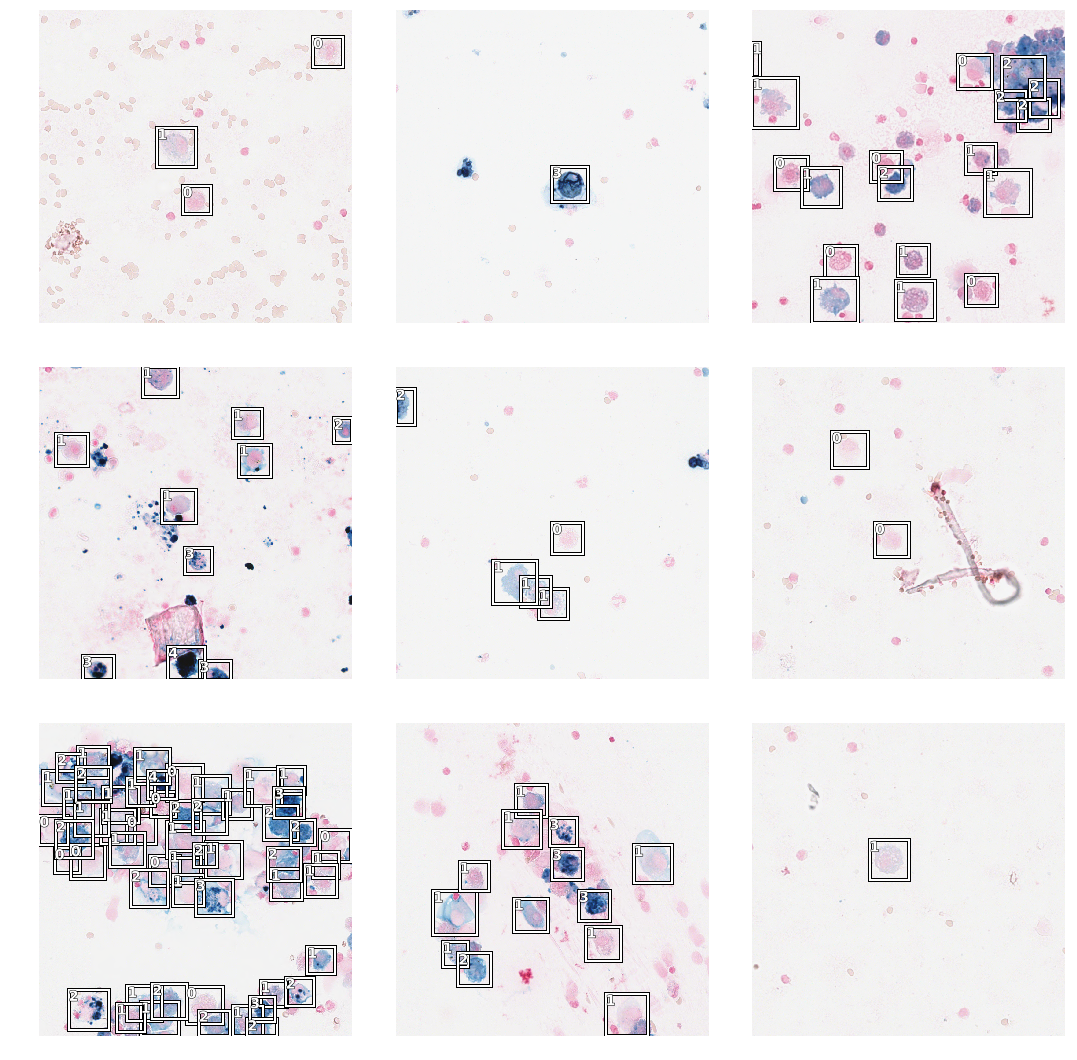

In [16]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

In [17]:
anchors = create_anchors(sizes=[(32,32)], ratios=[1], scales=[0.6, 0.7, 0.9, 1.25, 1.5])

In [18]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=5, sizes=[32], chs=128, final_bias=-4., n_conv=3)

In [19]:
voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=40)
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, partial(CSVLogger, append=True, filename=experiment_name)], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [20]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [21]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.714861,0.474820,0.303633,0.108422,0.366399,0.457838,0.435528,0.192402,0.424279,0.008121,05:06
1,0.387344,0.349365,0.477583,0.078971,0.270394,0.387057,0.644283,0.559821,0.297247,0.499503,04:46
2,0.283938,0.268554,0.645735,0.060674,0.207879,0.656379,0.732530,0.606392,0.486666,0.746709,04:41


In [22]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.288005,0.306996,0.636124,0.068477,0.238519,0.656383,0.678618,0.497853,0.611768,0.735999,04:42
1,0.357535,0.404389,0.459541,0.114362,0.290027,0.394242,0.733568,0.327621,0.521519,0.320753,04:37
2,0.367409,0.432079,0.313852,0.087691,0.344388,0.415530,0.439669,0.131353,0.396186,0.186523,04:16
3,0.375671,0.385099,0.451811,0.077791,0.307308,0.539756,0.490531,0.323946,0.443893,0.460931,04:14
4,0.301399,0.315775,0.538183,0.071574,0.244200,0.664498,0.727937,0.458234,0.422793,0.417455,04:22
5,0.275467,0.285103,0.622221,0.067502,0.217602,0.694509,0.683562,0.707891,0.348172,0.676974,04:29
6,0.247487,0.259136,0.653011,0.060345,0.198791,0.622671,0.734055,0.649637,0.626478,0.632214,04:24
7,0.223343,0.238846,0.590186,0.053787,0.185059,0.772345,0.746497,0.644875,0.408246,0.378967,04:19
8,0.203138,0.224793,0.715786,0.052787,0.172006,0.750882,0.757903,0.697871,0.673361,0.698913,04:14
9,0.192255,0.216136,0.718000,0.049686,0.166450,0.755478,0.754896,0.706319,0.621306,0.752003,04:16


In [23]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,pascal_voc_metric_by_distance,BBloss,focal_loss,AP-0,AP-1,AP-2,AP-3,AP-4,time
0,0.204376,0.232524,0.683567,0.052553,0.179971,0.745365,0.731475,0.707897,0.513063,0.720035,04:14
1,0.244378,0.265261,0.631183,0.060185,0.205076,0.657766,0.628460,0.674365,0.457532,0.737794,04:14
2,0.279819,0.480991,0.496262,0.072834,0.408157,0.053819,0.694181,0.522601,0.559950,0.650758,04:23
3,0.283154,0.278291,0.580982,0.062672,0.215619,0.577031,0.714582,0.550136,0.447826,0.615332,04:14
4,0.250312,0.273683,0.659075,0.072349,0.201334,0.629293,0.714059,0.688020,0.538779,0.725224,04:14
5,0.233618,0.249189,0.672810,0.059877,0.189312,0.607945,0.725659,0.659646,0.644669,0.726134,04:15
6,0.217626,0.240700,0.703261,0.056220,0.184480,0.745718,0.763113,0.559880,0.716890,0.730705,04:11
7,0.197916,0.215850,0.650046,0.046311,0.169539,0.654507,0.771525,0.731284,0.499094,0.593820,04:12
8,0.185689,0.209746,0.727965,0.045573,0.164174,0.766949,0.777416,0.696366,0.592055,0.807038,04:13
9,0.176173,0.199899,0.728039,0.045578,0.154321,0.755750,0.773774,0.717408,0.619804,0.773458,04:13


In [24]:
import pickle

stats = {"anchors": anchors,
         "mean": to_np(data.stats[0]),
         "std": to_np(data.stats[1]),
         "size": size,
         "n_classes": 6,
         "n_anchors": 5,
         "sizes": [32],
         "chs": 128,
         "encoder": "RN-18",
         "n_conv": 3,
         "level": 0,
         "model": get_model(learn.model).state_dict()
        }

torch.save(stats, "{}.p".format(experiment_name))

In [36]:
def rescale_box(bboxes, size: Tensor):
    bboxes[:, :2] = bboxes[:, :2] - bboxes[:, 2:] / 2
    bboxes[:, :2] = (bboxes[:, :2] + 1) * size / 2
    bboxes[:, 2:] = bboxes[:, 2:] * size / 2
    bboxes = bboxes.long()
    return bboxes

In [ ]:
debug_level = 1
with torch.no_grad():
    for slide_path in tqdm(test):
        
        slide_container = SlideContainer(slide_path, y=[[],[]],  level=level, width=size, height=size)

        result_boxes[slide_container.file.name] = []

        basepic = np.array(slide_container.slide.read_region(location=(0, 0),
                                                             level=debug_level,
                                                             size=slide_container.slide.level_dimensions[debug_level]))
        basepic = basepic[:, :, :3].astype(np.uint8)

        for x in range(0, slide_container.slide.level_dimensions[level][0] - 2 * size, 750): #int(size / 2)
            for y in range(0, slide_container.slide.level_dimensions[level][1] - 2 * size, 750): #int(size / 2)
                x_real = x  # * slide_container.down_factor, \
                y_real = y  # * slide_container.down_factor

                patch_ori = slide_container.get_patch(x, y)
                patch = pil2tensor(patch_ori / 255., np.float32)

                patch = transforms.Normalize(data.stats)(patch)

                class_pred_batch, bbox_pred_batch, _, regression_pred, bbox_regression_pred = learn.model.eval()(
                    patch[None, :, :, :])
                for clas_pred, bbox_pred, reg_pred, box_reg_pred in zip(class_pred_batch, bbox_pred_batch,
                                                                        regression_pred, bbox_regression_pred):

                    bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_thresh)

                    if bbox_pred is not None:
                        to_keep = nms(bbox_pred, scores, nms_thresh)
                        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
                        box_reg_pred = box_reg_pred[to_keep].cpu()

                        t_sz = torch.Tensor([size, size])[None].float()

                        bbox_pred = rescale_box(bbox_pred, t_sz)

                        patch_ori = patch_ori.astype(np.uint8)
                        for box, pred, score, bb_reg in zip(bbox_pred, preds, scores, box_reg_pred):
                            y_box, x_box = box[:2]
                            h, w = box[2:4]

                            result_boxes[slide_container.file.name].append(np.array([x_box + x_real, y_box + y_real,
                                                                                     x_box + x_real + w, y_box + y_real + h,
                                                                                     pred, score, bb_reg]))


        pickle.dump(result_boxes, open(str("inference_results_{}.p".format(experiment_name)), "wb"))